In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import datetime

import loader
import enedis_custom_metric_example as metrics
import data_vis as vis
import data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# LOAD DATA
min_timestamp = 1381694400
x_res, y_res, x_com, y_com, x_labels = loader.load_data(train_file_feat='training_input_qFI2jug.csv',
                                                        train_file_label='training_output_uamzSZW.csv',
                                                        test_file_feat = 'testing_input_BcjTmnd.csv',
                                                        min_timestamp=min_timestamp)
n_res, n_com = x_res.shape[0], y_res.shape[0]

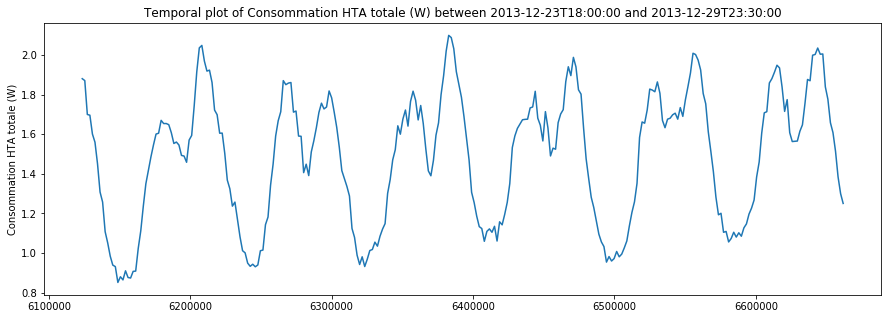

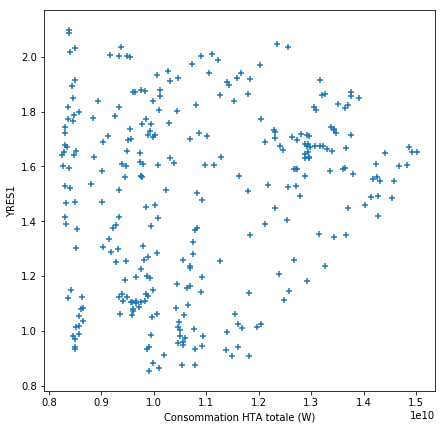

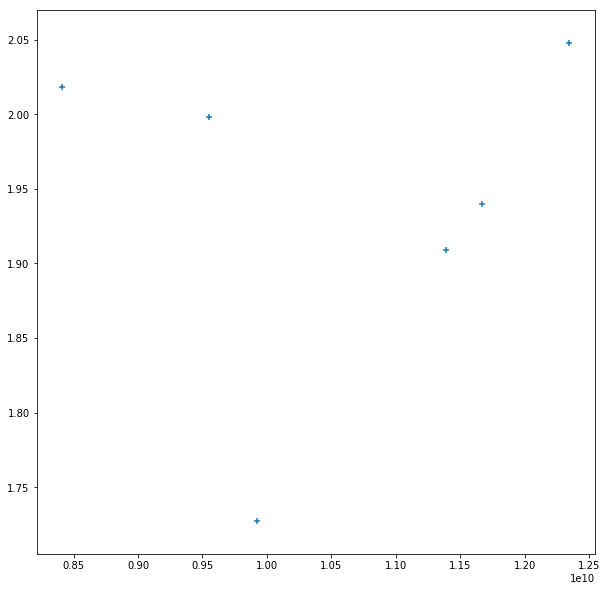

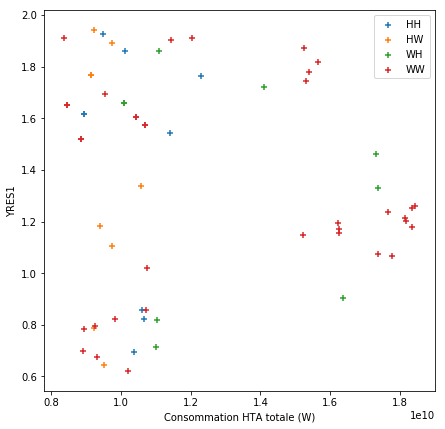

In [124]:
# PLOT DATA
min_id = 3400
max_id = min_id+300
x_id = 23
y_id = 1

plt.figure(figsize=(15, 5))
vis.plot_time(x_res[min_id:max_id, 1], y_res[min_id:max_id, y_id], label_x=x_labels[x_id])
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_series(x_res[min_id:max_id, x_id], y_res[min_id:max_id, y_id], 
                label_a=x_labels[x_id], label_b='YRES{}'.format(y_id))
plt.show()

plt.figure(figsize=(10, 10))
vis.plot_series(x_res[min_id+k:max_id:48, x_id], y_res[min_id+k:max_id:48, y_id])
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_dayclass(x_res, y_res, x_labels, x_id, y_id, min_id, max_id)
plt.savefig('HTA_dayclass_{}_{}.png'.format(x_id, y_id))
plt.show()

Proportion of the validation set: 12.3%


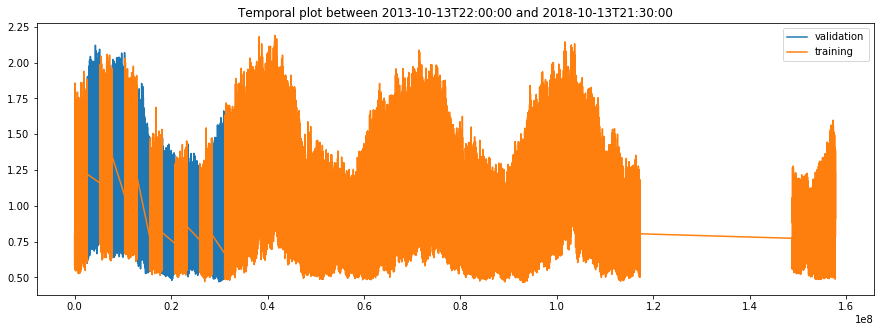

In [98]:
is_valid = data.separate_x_res(n_res)
print('Proportion of the validation set: {:.1f}%'.format(100 * np.sum(is_valid)/n_res))

plt.figure(figsize=(15, 5))
ind = np.where(is_valid)[0]
vis.plot_time(x_res[ind, 1], y_res[ind, 0], label_curve='validation')
ind = np.where([not is_valid[i] for i in range(x_res.shape[0])])[0]
vis.plot_time(x_res[ind, 1], y_res[ind, 0], label_curve='training')
plt.legend(loc='best')
plt.show()

In [140]:
def create_features(x_train, min_timestamp=1381694400):
    day_labels = ['HH', 'HW', 'WH', 'WW']
    n, m = x_train.shape
    features = np.zeros((0, ))
    for i in range(n):
        t = x_train[i, 1]
        dt = datetime.datetime.fromtimestamp(t + min_timestamp)
        datestring = '{:02d}/{:02d}/{}'.format(dt.day, dt.month, dt.year)
        print(datestring)
        weekday = dt.weekday()
# print(create_features(x_res))
holidays = data.holiday_list()
data.dayclass(x_res[0, 1], holidays)

2013-10-13 22:00:00 6


'HH'